In [1]:
using PyPlot
using Random
using Distributions

In [2]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

In [3]:
t = Array(2020:1.:2200);

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
)

Economics(0.2222222222222222, 0.025, 1.0, 2.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [4]:
ECS=3.0

3.0

In [5]:
ensemble = Dict{String, ClimateModel}();

name = "2020";
controls = init_linear_controls(t);
present_year = 2020.

model = ClimateModel(name, ECS, t, controls, economics, present_year);

In [6]:
optimize!(model)
ensemble[model.name] = model;

Converged after 558 iterations. 

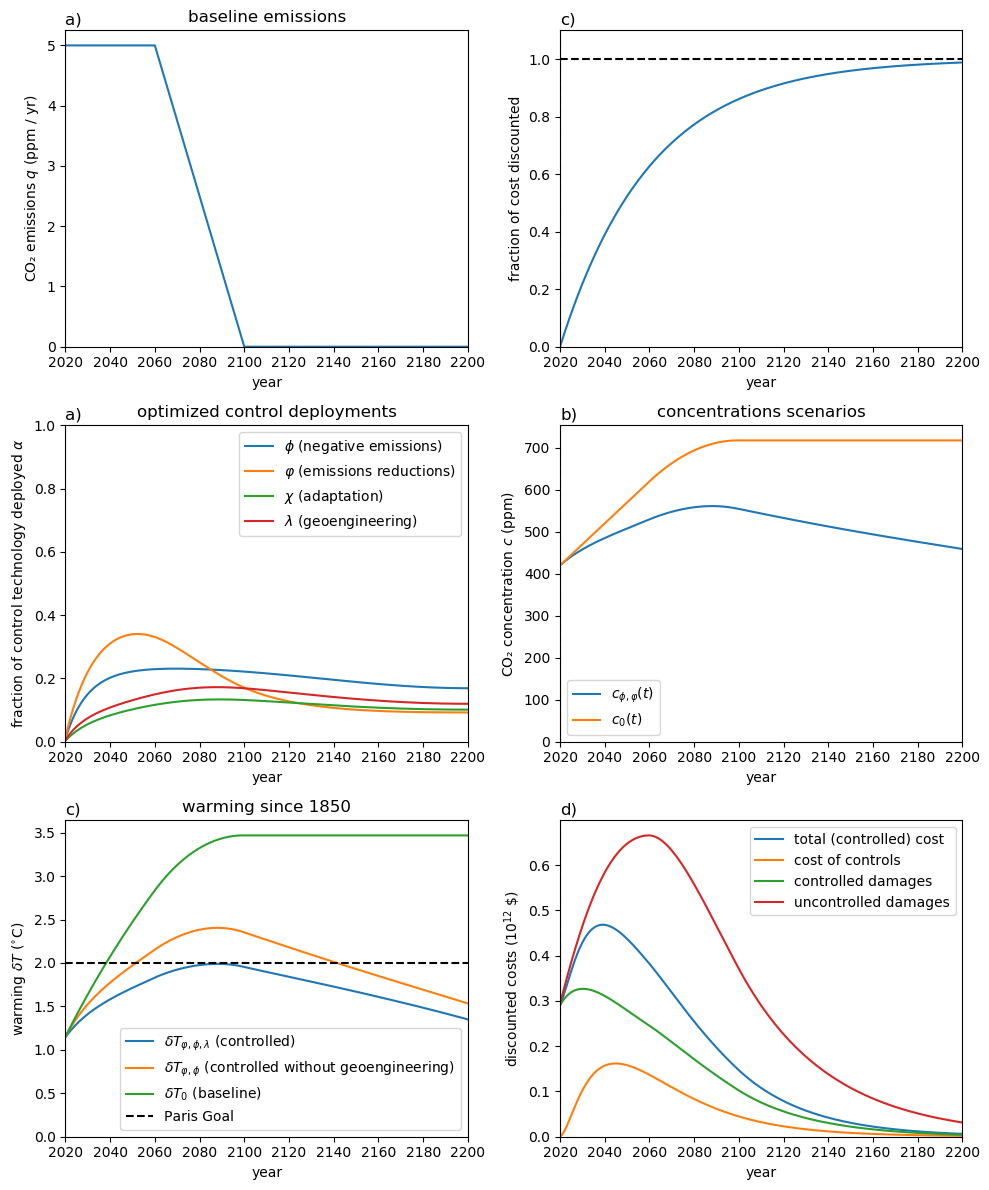

In [7]:
plot_state(model)

In [8]:
function step_forward(model::ClimateModel, Δt::Float64, q0::Float64, t0::Float64, Δt0::Float64)

    present_year = deepcopy(model.present_year) + Δt
    present_idx = deepcopy(argmin(abs.(model.domain .- present_year)))
    name = string(Int64(round(present_year)));
    
    controls = Controls(
        deepcopy(model.controls.reduce),
        deepcopy(model.controls.remove),
        deepcopy(model.controls.geoeng),
        deepcopy(model.controls.adapt)
    )
    
    new_emissions = zeros(size(model.domain))
    new_emissions[model.domain .< model.present_year] = deepcopy(model.economics.baseline_emissions)[model.domain .< model.present_year]
    new_emissions[model.domain .>= model.present_year] = deepcopy(baseline_emissions(model.domain, q0, t0, Δt0))[model.domain .>= model.present_year]
    #new_emissions = deepcopy(baseline_emissions(model.domain, q0, t0, Δt0))
    
    economics = Economics(
        β, utility_discount_rate,
        reduce_cost, remove_cost, geoeng_cost, adapt_cost,
        0., 0., 0., 0.,
        new_emissions
    )
    model = ClimateModel(
        model.name, model.ECS, model.domain, controls, economics, present_year,
    );
    return model
end

step_forward(model::ClimateModel, Δt::Float64, q0::Float64) = step_forward(model::ClimateModel, Δt::Float64, q0::Float64, 2060., 40.)
step_forward(model::ClimateModel, Δt::Float64) = step_forward(model::ClimateModel, Δt::Float64, 5., 2060., 40.)

step_forward (generic function with 3 methods)

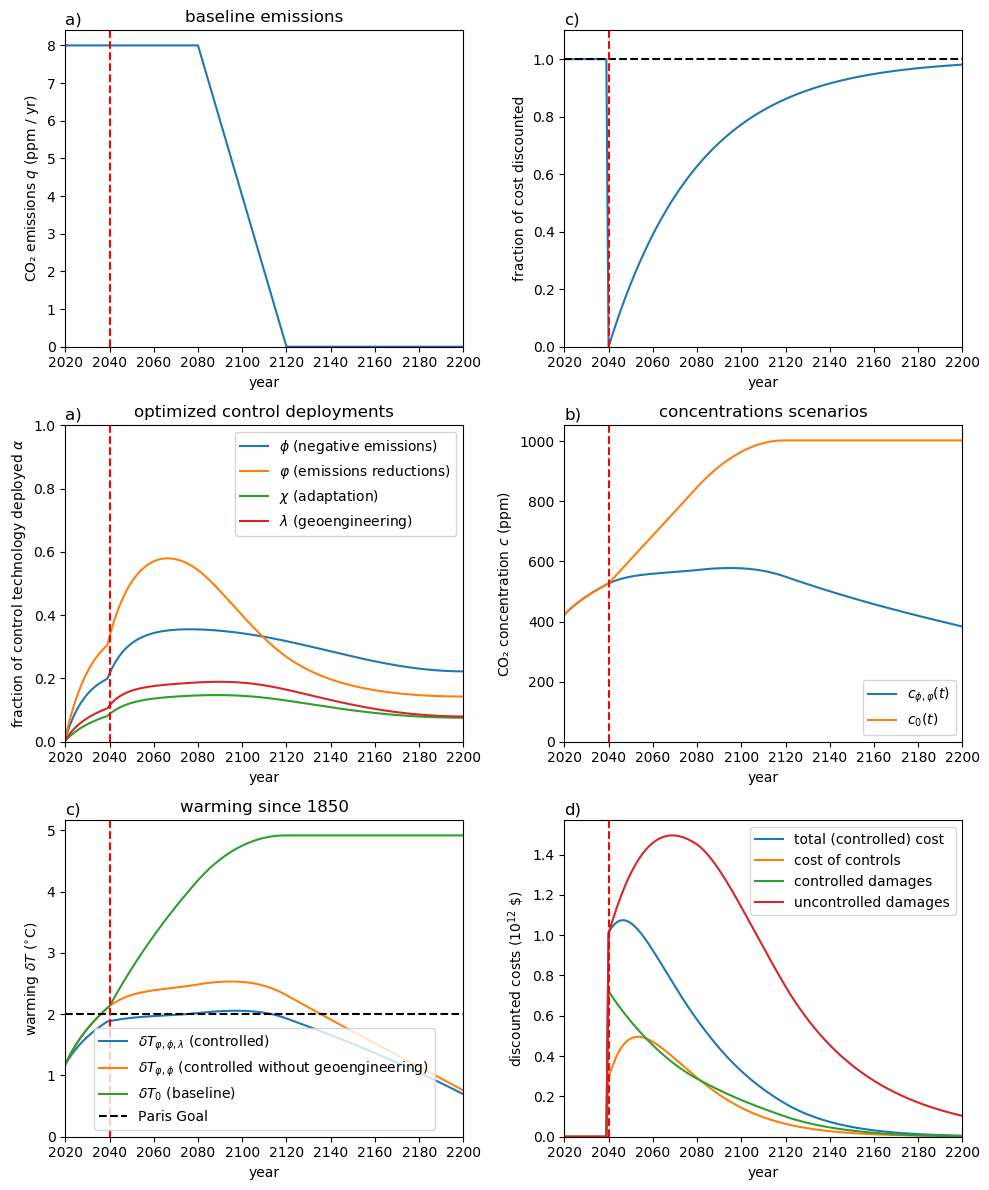

Converged after 399 iterations. 

In [9]:
model = step_forward(model, 20., 8., 2080., 40.)
optimize!(model)
plot_state(model)
ensemble[model.name] = model;

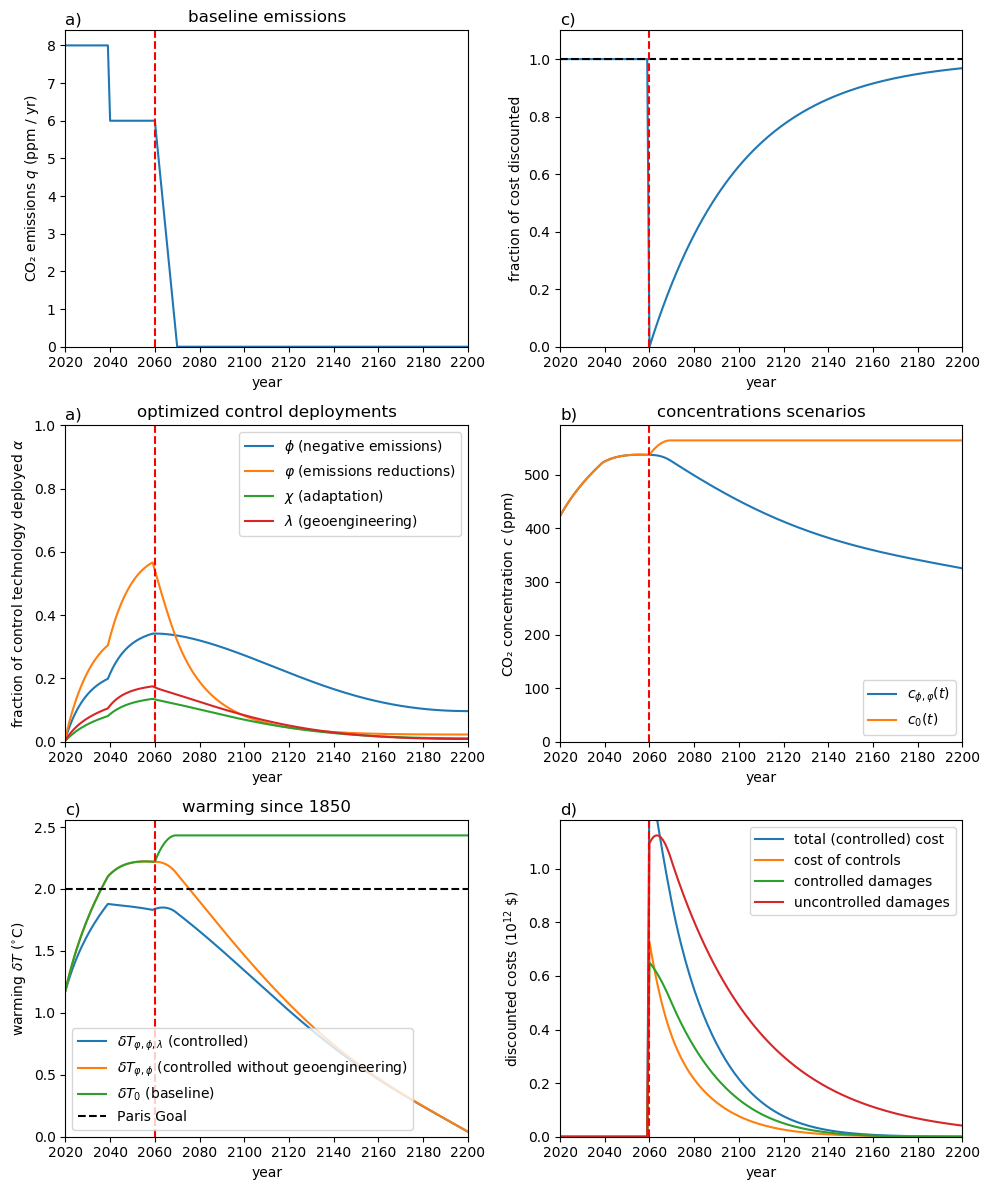

Converged after 329 iterations. 

In [10]:
model = step_forward(model, 20., 6., 2060., 10.)
optimize!(model)
plot_state(model)
ensemble[model.name] = model;